In [17]:
from ParallelSolve import gurobi_SSKP, majority_vote
import time

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [29]:
# generate pareto distributed samples
def genPareto(n, rng, paretoShape):
    return stats.lomax.rvs(paretoShape, size=n, random_state=rng) + 1

def genTruncatedNormal(n, rng, mean, std):
     return np.maximum(stats.norm.rvs(loc=mean, scale=std, size=n, random_state=rng),0)

def genSample_SSKP(n, rng, **kwargs):
     arrays_list = []
     if kwargs['type'] == 'pareto':
          paretoShapes = kwargs['params']
          for i in range(len(paretoShapes)):
               arrays_list.append(genPareto(n, rng, paretoShapes[i]))
     elif kwargs['type'] == 'normal':
          mean, std = kwargs['params'][0], kwargs['params'][1]
          for i in range(len(mean)):
               arrays_list.append(genTruncatedNormal(n, rng, mean[i], std[i]))
     else:
          raise ValueError('Invalid type')
     return np.vstack(arrays_list).T 

In [19]:
# objective evaluation
def SSKP_eval(sample, x, r, c, q):
     # sample: large number * m matrix
     expected_cost = 0
     for w in sample:
          expected_cost += max(sum(w[i] * x[i] for i in range(len(x)))-q, 0)
     expected_cost = expected_cost/len(sample)
     opt = sum(r[i] * x[i] for i in range(len(x))) - c * expected_cost
     return opt

In [45]:
# functions that implements the comparison between SAA and Bagging-SAA, as well as evaluating the results
def comparison_final(B_list,k_list,number_of_iterations,sample_number,rng, sample_args, *prob_args):
    # a unified function that compare SAA with different configurations of Bagging
    # prob_args: r,c,q
    # sample_args: paretoShapes
    # remark: r and paretoShapes automatically imply the number of products
    SAA_list = []
    bagging_list = [[ [] for _ in range(len(k_list)) ] for _ in range(len(B_list))] 
    for n in sample_number:
        SAA_intermediate = []
        bagging_intermediate = [[ [] for _ in range(len(k_list)) ] for _ in range(len(B_list))]
        for _ in range(number_of_iterations):
            tic = time.time()
            sample_n = genSample_SSKP(n, rng, type = sample_args['type'], params = sample_args['params'])
            SAA = majority_vote(sample_n, 1, n, gurobi_SSKP, rng, *prob_args)
            SAA_intermediate.append(tuple([round(x) for x in SAA]))
            print(f"Sample size {n}, iteration {_}, SAA time: {time.time()-tic}")

            for ind1, B in enumerate(B_list):
                for ind2, k in enumerate(k_list):
                    tic = time.time()
                    if k < 1:
                        bagging = majority_vote(sample_n, B, int(n*k), gurobi_SSKP, rng, *prob_args)
                    else:
                        bagging = majority_vote(sample_n, B, k, gurobi_SSKP, rng, *prob_args)
                    bagging_intermediate[ind1][ind2].append(tuple([round(x) for x in bagging]))
                    print(f"Sample size {n}, iteration {_}, B={B}, k={k}, Bagging time: {time.time()-tic}")
            
        SAA_list.append(SAA_intermediate)
        for ind1 in range(len(B_list)):
            for ind2 in range(len(k_list)):
                bagging_list[ind1][ind2].append(bagging_intermediate[ind1][ind2])
    
    return SAA_list, bagging_list

        
def evaluation_final(SAA_list, bagging_list, large_number_sample, rng, sample_args, *prob_args):
    sample_number_len = len(SAA_list)
    number_of_iterations = len(SAA_list[0])
    B_list_len, k_list_len = len(bagging_list), len(bagging_list[0])
    all_solutions = set()
    for i in range(sample_number_len):
        for j in range(number_of_iterations):
            all_solutions.add(SAA_list[i][j])
            for ind1 in range(B_list_len):
                for ind2 in range(k_list_len):
                    all_solutions.add(bagging_list[ind1][ind2][i][j])
    
    solution_obj_values = {str(solution): 0 for solution in all_solutions}

    for solution in all_solutions:
        sample_large = genSample_SSKP(large_number_sample, rng, type = sample_args['type'], params = sample_args['params'])
        obj_value = SSKP_eval(sample_large, solution, *prob_args)
        solution_obj_values[str(solution)] = obj_value
    
    SAA_obj_list, SAA_obj_avg = [], []
    bagging_obj_list, bagging_obj_avg = [[ [] for _ in range(k_list_len) ] for _ in range(B_list_len)], [[ [] for _ in range(k_list_len) ] for _ in range(B_list_len)]
    for i in range(sample_number_len):
        current_SAA_obj_list = []
        for j in range(number_of_iterations):
            SAA_obj = solution_obj_values[str(SAA_list[i][j])]
            current_SAA_obj_list.append(SAA_obj)
        SAA_obj_list.append(current_SAA_obj_list)
        SAA_obj_avg.append(np.mean(current_SAA_obj_list))

    for ind1 in range(B_list_len):
        for ind2 in range(k_list_len):
            for i in range(sample_number_len):
                current_bagging_obj_list = []
                for j in range(number_of_iterations):
                    bagging_obj = solution_obj_values[str(bagging_list[ind1][ind2][i][j])]
                    current_bagging_obj_list.append(bagging_obj)
                bagging_obj_list[ind1][ind2].append(current_bagging_obj_list)
                bagging_obj_avg[ind1][ind2].append(np.mean(current_bagging_obj_list))
    
    return SAA_obj_list, SAA_obj_avg, bagging_obj_list, bagging_obj_avg

        
def plot_final(SAA_obj_avg, bagging_obj_avg, sample_number, B_list, k_list):
    _, ax = plt.subplots()
    ax.plot(sample_number, SAA_obj_avg, marker = 'o', markeredgecolor = 'none', color = 'blue',linestyle = 'solid', linewidth = 2, label = 'SAA')
    for ind1, B in enumerate(B_list):
        for ind2, k in enumerate(k_list):
            if B == "X" or k == "X":
                continue
            ax.plot(sample_number, bagging_obj_avg[ind1][ind2], marker = 's', markeredgecolor = 'none', linestyle = 'solid', linewidth = 2, label = f'B={B_list[ind1]}, k={k_list[ind2]}')
    ax.set_xlabel('Number of samples', size = 20)
    ax.set_ylabel('Objective', size = 20)
    ax.legend()
    plt.show()
    return

def plot_CI_final(SAA_obj_list, bagging_obj_list, sample_number, B_list, k_list):
    number_of_iterations = len(SAA_obj_list[0])
    _, ax = plt.subplots()
    for ind1, B in enumerate(B_list):
        for ind2, k in enumerate(k_list):
            if B == "X" or k == "X":
                continue
            diff_Bk = []
            for i in range(len(sample_number)):
                diff_Bk.append([bagging_obj_list[ind1][ind2][i][j] - SAA_obj_list[i][j] for j in range(number_of_iterations)])
            
            diff_Bk_mean = np.mean(diff_Bk, axis = 1)
            diff_Bk_std_err = stats.sem(diff_Bk, axis = 1)
            diff_conf_int = 1.96 * diff_Bk_std_err

            ax.plot(sample_number, diff_Bk_mean, marker = 's', markeredgecolor = 'none', linestyle = 'solid', linewidth = 2, label = f'B={B}, k={k}')
            ax.fill_between(sample_number, diff_Bk_mean - diff_conf_int, diff_Bk_mean + diff_conf_int, alpha = 0.2)
    
    ax.axhline(0, color='grey', linewidth=2, linestyle='--') 
    ax.set_xlabel('Number of samples', size = 20)
    ax.set_ylabel('Objective difference', size = 20)
    ax.legend()
    plt.show()
    return

In [41]:
# a good set of pamaeters for the three-product case

r = [3.2701236422941093, 3.3207149493214994, 3.556858029428708]
c, q = 3.7856629820554946, 1.7096129150007453
# sample_args = {
#         'type': 'pareto',
#         'params': [2.0033248484659976, 1.9462659915572313, 2.0148555044660448]
#     }
sample_args = {
        'type': 'normal',
        'params': [[2,1.9,2.1], [1,1,1]]
    }

In [48]:
rng = np.random.default_rng(seed=2024)

B_list = [50, 100, 200]
k_list = [0.1, 0.2, 2, 10, 50]
number_of_iterations = 50
sample_number = np.array([2**i for i in range(6, 14)])
large_number_sample = 1000000

tic = time.time()
SAA_list, bagging_list = comparison_final(B_list, k_list, number_of_iterations, sample_number, rng, sample_args, r, c, q)
SAA_obj_list, SAA_obj_avg, bagging_obj_list, bagging_obj_avg = evaluation_final(SAA_list, bagging_list, large_number_sample, rng, sample_args, r, c,q)
print(f"Total time: {time.time()-tic}")

Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Sample size 64, iteration 0, SAA time: 0.16090774536132812
Set parameter Username
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Academic license - for non-commercial use only - expires 2025-03-13
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Academic license - for non-commercial use only - expires 2025-03-13
Academic license - for non-commercial use only - expires 2025-03-13
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Sample size 64, iteration 0, B=

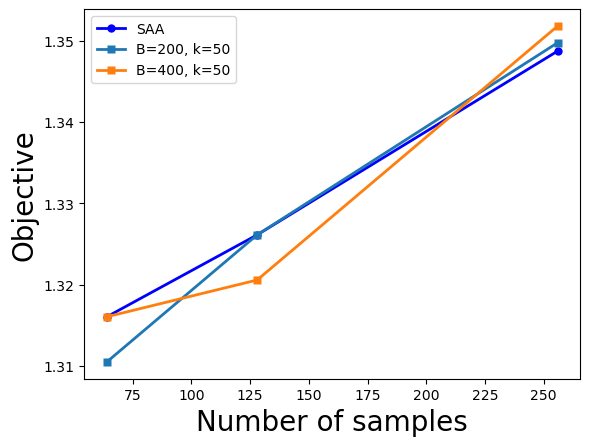

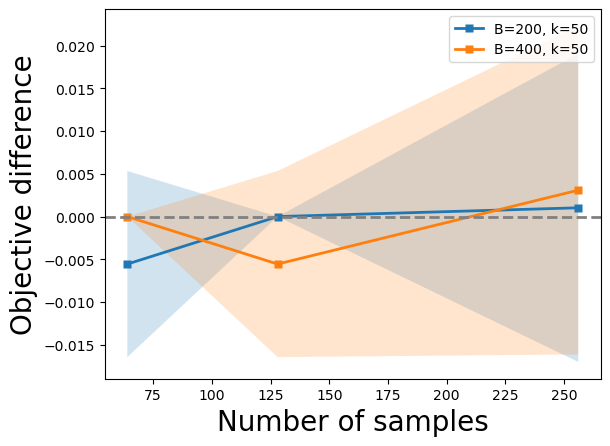

In [47]:
B_list = ['X', 'X', 200, 400]
k_list = ['X', 'X', 'X', 'X', 'X', 50]
plot_final(SAA_obj_avg, bagging_obj_avg, sample_number, B_list, k_list)
plot_CI_final(SAA_obj_list, bagging_obj_list, sample_number, B_list, k_list)

In [5]:
# script to find good parameters for display
def find_parameters(m, B,number_of_iterations,ratio,sample_number, large_number_sample, rng):
    top_parameters= []

    for _ in range(30):
        a_ls = np.random.uniform(1.7,2.3, size=m)
        r = np.random.uniform(3, 4, size=m)
        c = float(np.random.uniform(3, 4, size=1)[0])
        q = float(np.random.uniform(0, 2, size=1)[0])
        
        SAA_list, majority_list = comparison(m,r,c,q,a_ls,B,number_of_iterations,ratio,sample_number, rng)
        _, _, SAA_obj_list, majority_obj_list = evaluation_CI(SAA_list, majority_list, m, r, c, q, a_ls, number_of_iterations, sample_number, large_number_sample, rng)

        prop = sum((majority_obj_list[i] - SAA_obj_list[i])/majority_obj_list[i] for i in range(len(sample_number)//2,len(sample_number)))
        top_parameters.append((prop, [a_ls.tolist(), r.tolist(),c,q], SAA_list, majority_list, SAA_obj_list, majority_obj_list))
        top_parameters.sort(key = lambda x: x[0], reverse = True)
    
    results = []
    for prop, params, SAA_list, majority_list, SAA_obj_list, majority_obj_list in top_parameters:
        result = {
            'parameters': params,
            'SAA_list': SAA_list,
            'majority_list': majority_list,
            'SAA_obj_list': SAA_obj_list,
            'majority_obj_list': majority_obj_list
        }
        results.append(result)
        
    return results
        

In [ ]:
tic = time.time()

m = 3 # Number of items
B = 400 # Batch size
number_of_iterations = 20 # Number of repeated evaluations
ratio = 0.1 # Proportion of samples used in Bagging-SAA
sample_number = np.array([2**i for i in range(8, 17)])
large_number_sample = 1000000 # Number of large samples used in evaluation
results = find_parameters(m, B, number_of_iterations,ratio,sample_number, large_number_sample, rng)

print(f"time = {time.time() - tic} secs")

In [ ]:
for result in results:
    print(f"parameters: {result['parameters']}")
    figure_plot(result['SAA_obj_list'], result['majority_obj_list'], sample_number)
    print("\n")

# criterion 1
# abs(result['majority_obj_list'][-1] - result['majority_obj_list'][0]) > 0.01:

# criterion 2
# sum_saa = sum(result['SAA_obj_list'][i] for i in range(len(sample_number)))
# sum_majority = sum(result['majority_obj_list'][i] for i in range(len(sample_number)))
# if sum_saa < sum_majority:

In [ ]:
# write and read data
with open("results_8_17.json", "w") as f:
    json.dump(results_cc, f, indent=2)

with open("results_8_17.json", "r") as f:
    resultsss = json.load(f)

In [5]:
# Good parameter, used for test
m = 3 # Number of items
a_ls = [2.0033248484659976, 1.9462659915572313, 2.0148555044660448]
r = [3.2701236422941093, 3.3207149493214994, 3.556858029428708]
c, q = 3.7856629820554946, 1.7096129150007453

In [8]:
n = 2
SAA_list = []
rng = np.random.default_rng(seed=2024)
for _ in range(500):
    arrays_list = []
    for i in range(m):
        arrays_list.append(sample_func(rng, 'pareto', size=n, a=a_ls[i]))
    sample_n = np.vstack(arrays_list).T 

    SAA = majority_vote(sample_n, 1, n, gurobi_SSKP, rng, r,c,q)
    SAA_list.append(tuple([round(x) for x in SAA]))

all_solutions = []
for sol in SAA_list:
    if sol not in all_solutions:
        all_solutions.append(sol)

solution_obj_values = {str(solution): 0 for solution in all_solutions}

for solution in all_solutions:
    arrays_list = []
    for i in range(m):
        arrays_list.append(sample_func(rng, 'pareto', size=1000000, a=a_ls[i]))
    large_sample = np.vstack(arrays_list).T
    obj_value = SSKP_eval(large_sample, solution, r, c, q)
    solution_obj_values[str(solution)] = obj_value

SAA_obj_list = []
for sol in SAA_list:
    SAA_obj = solution_obj_values[str(sol)]
    SAA_obj_list.append(SAA_obj)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13

In [42]:
rng = np.random.default_rng(seed=1024)
n = 512
ratio_list = [0.005, 0.01, 0.05, 0.1, 0.2, 0.4]
SAA_list_R = [ [] for _ in range(len(ratio_list)) ]

arrays_list = []
for i in range(m):
    arrays_list.append(sample_func(rng, 'pareto', size=n, a=a_ls[i]))
sample_n = np.vstack(arrays_list).T 

for i in range(len(ratio_list)):
    for _ in range(200):
        sample_k = sample_n[rng.choice(n, int(n*ratio_list[0]), replace=False)]
        SAA = majority_vote(sample_k, 1, int(n*ratio_list[0]), gurobi_SSKP, rng, r,c,q)
        SAA_list_R[i].append(tuple([round(x) for x in SAA]))

all_solutions = []
for SAA_list in SAA_list_R:
    for sol in SAA_list:
        if sol not in all_solutions:
            all_solutions.append(sol)

solution_obj_values = {str(solution): 0 for solution in all_solutions}

for solution in all_solutions:
    arrays_list = []
    for i in range(m):
        arrays_list.append(sample_func(rng, 'pareto', size=1000000, a=a_ls[i]))
    large_sample = np.vstack(arrays_list).T
    obj_value = optimal_eval(large_sample, solution, r, c, q)
    solution_obj_values[str(solution)] = obj_value

SAA_obj_list_R = [ [] for _ in range(len(ratio_list)) ]
for i in range(len(ratio_list)):
    for sol in SAA_list_R[i]:
        SAA_obj = solution_obj_values[str(sol)]
        SAA_obj_list_R[i].append(SAA_obj)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13

In [45]:
print([np.mean(SAA_obj_list_R[i]) for i in range(len(ratio_list))])

[0.5663385658406014, 0.47218932148563203, 0.42599361359109084, 0.42487853652643237, 0.3560172063795519, 0.18765752016815182]


ratio = 0.005
mean = 0.5663385658406014
number of negative = 16


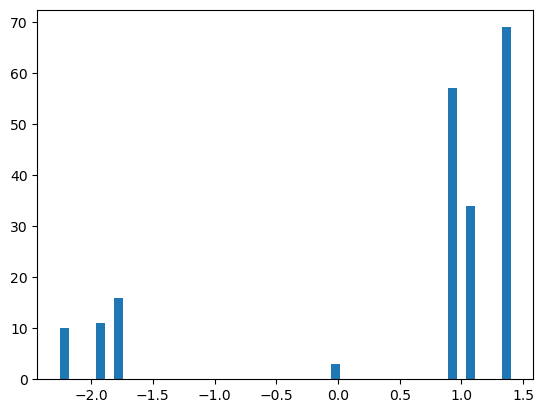

ratio = 0.01
mean = 0.47218932148563203
number of negative = 24


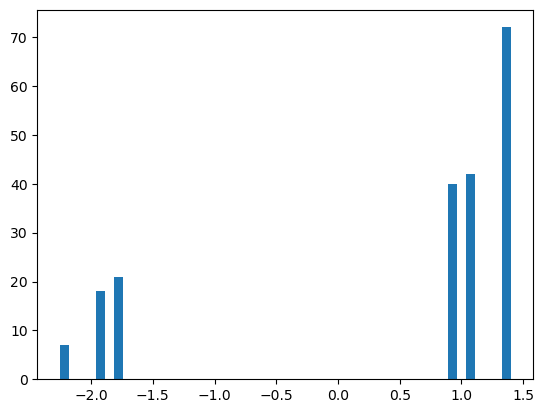

ratio = 0.05
mean = 0.42599361359109084
number of negative = 23


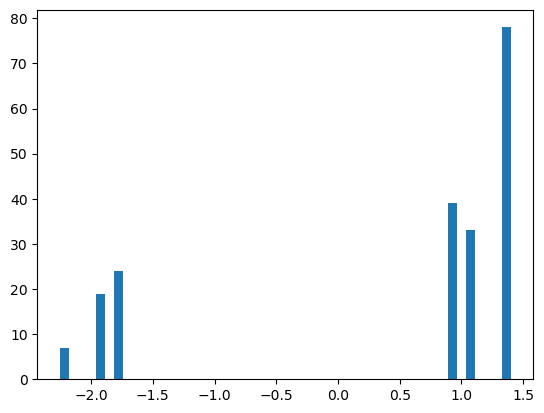

ratio = 0.1
mean = 0.42487853652643237
number of negative = 23


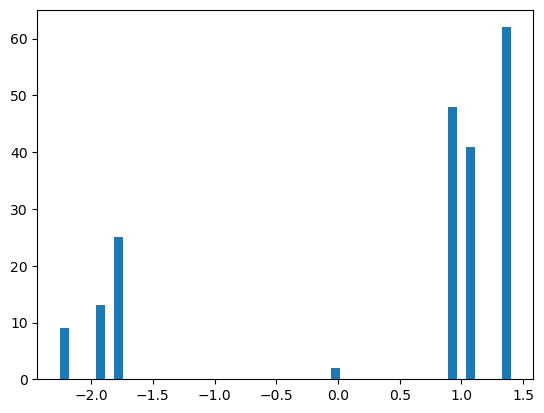

ratio = 0.2
mean = 0.3560172063795519
number of negative = 23


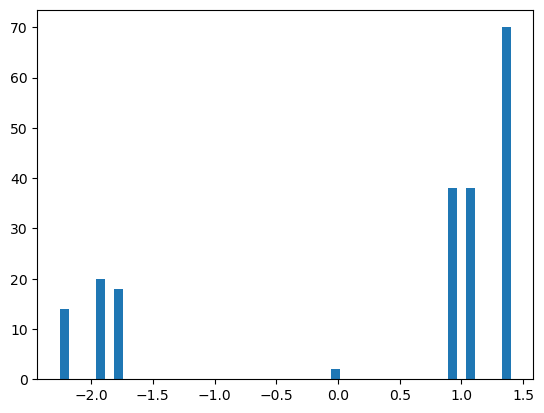

ratio = 0.4
mean = 0.18765752016815182
number of negative = 37


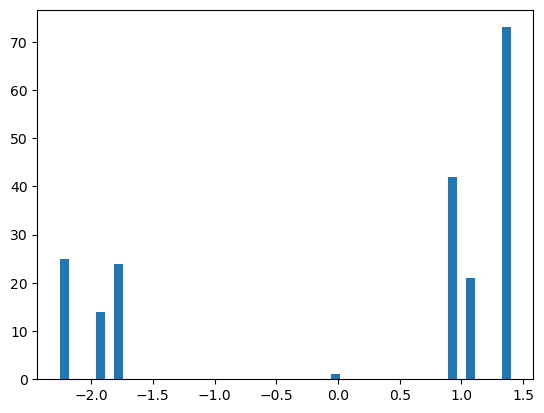

In [44]:
for i in range(len(ratio_list)):
    print(f"ratio = {ratio_list[i]}")
    print(f"mean = {np.mean(SAA_obj_list_R[i])}")
    print(f"number of negative = {sum(SAA_obj_list_R[i][j] < 0 for j in range(100))}")
    plt.hist(SAA_obj_list_R[i], bins=50)
    plt.show()

(array([15.,  0.,  0.,  0.,  0.,  0.,  0., 26.,  0.,  0., 20.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0., 39.,  0.,  0.,  0., 39.,  0.,  0.,  0.,  0.,
         0., 59.]),
 array([-2.29403273, -2.24805467, -2.2020766 , -2.15609854, -2.11012048,
        -2.06414242, -2.01816436, -1.9721863 , -1.92620824, -1.88023018,
        -1.83425212, -1.78827406, -1.742296  , -1.69631793, -1.65033987,
        -1.60436181, -1.55838375, -1.51240569, -1.46642763, -1.42044957,
        -1.37447151, -1.32849345, -1.28251539, -1.23653733, -1.19055927,
        -1.1445812 , -1.09860314, -1.05262508, -1.00664702, -0.96066896,
        -0.9146909 , -0.86871284, -0.82273478, -0.77675672, -0.73077866,
        -0.6848006 , -0.6388225

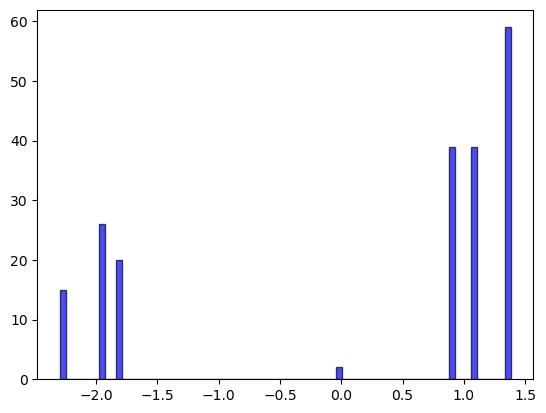

In [16]:
# 64/200
plt.hist(SAA_obj_list, bins=80, alpha=0.7, color='blue', edgecolor='black')  

In [14]:
# scripts to test the effects of batch size
def comparison_B(m,r,c,q,a_ls,B_list,number_of_iterations,ratio,sample_number, rng):
    SAA_list= []
    majority_list_B = [[] for _ in B_list]
    for n in sample_number:
        SAA_intermediate = []
        majority_intermediates = [[] for _ in B_list]  
        for j in range(number_of_iterations):
            if j == 2:
                return
            arrays_list = []
            for i in range(m):
                arrays_list.append(sample_func(rng, 'pareto', size=n, a=a_ls[i]))
            sample_n = np.vstack(arrays_list).T 

            SAA = majority_vote(sample_n, 1, n, gurobi_SSKP, rng, r,c,q)
            SAA_intermediate.append(tuple([round(x) for x in SAA]))

            for ind, B in enumerate(B_list):
                print("n = ", n, "j = ", j, "B = ", B)
                majority = majority_vote(sample_n, B, int(n*ratio), gurobi_SSKP, rng, r,c,q)
                majority_intermediates[ind].append(tuple([round(x) for x in majority]))
            
        SAA_list.append(SAA_intermediate)
        for ind in range(len(B_list)):
            majority_list_B[ind].append(majority_intermediates[ind])
    
    return SAA_list, majority_list_B

def evaluation_CI_B(SAA_list, majority_list_B, m, r, c, q, a_ls, number_of_iterations, sample_number, large_number_sample, rng):    
    all_solutions = []
    for i in range(len(sample_number)):
        for j in range(number_of_iterations):
            if SAA_list[i][j] not in all_solutions:
                all_solutions.append(SAA_list[i][j])

    for majority_list in majority_list_B:
        for i in range(len(sample_number)):
            for j in range(number_of_iterations):
                if majority_list[i][j] not in all_solutions:
                    all_solutions.append(majority_list[i][j])
    
    solution_obj_values = {str(solution): 0 for solution in all_solutions}
    
    for solution in all_solutions:
        arrays_list = []
        for i in range(m):
            arrays_list.append(sample_func(rng, 'pareto', size=large_number_sample, a=a_ls[i]))
        large_sample = np.vstack(arrays_list).T
        obj_value = optimal_eval(large_sample, solution, r, c, q)
        solution_obj_values[str(solution)] = obj_value
    
    SAA_obj_lists, majority_obj_lists_B, SAA_obj_list, majority_obj_list_B = [], [[] for _ in range(len(majority_list_B))], [], [[] for _ in range(len(majority_list_B))]
    for i in range(len(sample_number)):
        current_SAA_obj_list = []
        
        for j in range(number_of_iterations):
            SAA_obj = solution_obj_values[str(SAA_list[i][j])]
            current_SAA_obj_list.append(SAA_obj) 
        
        SAA_obj_lists.append(current_SAA_obj_list)
        SAA_obj_list.append(np.mean(current_SAA_obj_list))

    for ind in range(len(majority_list_B)):
        for i in range(len(sample_number)):
            current_majority_obj_list = []
            for j in range(number_of_iterations):
                majority_obj = solution_obj_values[str(majority_list_B[ind][i][j])]
                current_majority_obj_list.append(majority_obj)
            majority_obj_lists_B[ind].append(current_majority_obj_list)
            majority_obj_list_B[ind].append(np.mean(current_majority_obj_list))
    
    return SAA_obj_lists, majority_obj_lists_B, SAA_obj_list, majority_obj_list_B


def figure_plot_B(SAA_obj_list, majority_obj_list_B, sample_number, B_list):
    _, ax = plt.subplots()
    ax.plot(sample_number, SAA_obj_list, marker = 'o', markeredgecolor = 'none', color = 'blue',linestyle = 'solid', linewidth = 2, label = 'SAA')
    for ind in range(len(majority_obj_list_B)):
        ax.plot(sample_number, majority_obj_list_B[ind], marker = 's', markeredgecolor = 'none', linestyle = 'solid', linewidth = 2, label = f'Bagging, B = {B_list[ind]}')
    ax.set_xlabel('Number of samples', size = 20)
    ax.set_ylabel('Objective', size = 20)
    ax.legend(loc = 'lower right')
    plt.show()
    return


In [24]:
# test the effects of batch size. 
ratio = 0.1 # Proportion of samples used in Bagging-SAA
B_list = [10, 50, 200, 400, 410]
number_of_iterations = 50 # Number of repeated evaluations
sample_number = np.array([2**i for i in range(7, 16)])
large_number_sample = 1000000 # Number of large samples used in evaluation

SAA_list, majority_list_B = comparison_B(m,r,c,q,a_ls,B_list,number_of_iterations,ratio,sample_number, rng)
SAA_obj_lists, majority_obj_lists_B, SAA_obj_list, majority_obj_list_B = evaluation_CI_B(SAA_list, majority_list_B, m, r, c, q, a_ls, number_of_iterations, sample_number, large_number_sample, rng)
figure_plot_B(SAA_obj_list, majority_obj_list_B, sample_number, B_list)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
n =  128 j =  0 B =  10
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Set parameter Username
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Academic license - for non-commercial use only - expires 2025-03-13
Academic license - for non-commercial use only - expires 2025-03-13
Academic license - for non-commercial use only - expires 2025-03-13
n =  128 j =  0 B =  50
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-13
Set parameter Username
Academic license - 

KeyboardInterrupt: 

In [25]:
import json
with open("obj_lists.json", "r") as f:
    results = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'obj_lists.json'

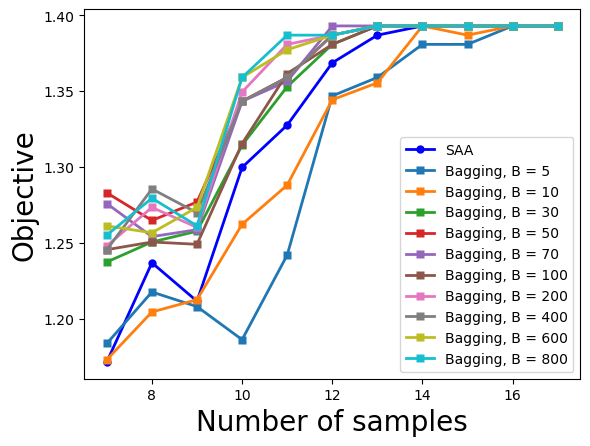

In [85]:
B_list = [5, 10, 30, 50, 70, 100, 200, 400, 600, 800]
sample_number = np.array([2**i for i in range(7, 18)])
sample_number_log = np.log2(sample_number) 
figure_plot_B(results["SAA_obj_list"], results["majority_obj_list_B"], sample_number_log, B_list)

In [86]:
SAA_obj_lists = results["SAA_obj_lists"]
majority_obj_lists_B = results["majority_obj_lists_B"]

In [87]:
print(np.shape(SAA_obj_lists))
print(np.shape(majority_obj_lists_B))

(11, 50)
(10, 11, 50)


In [55]:
def figure_plot_B_CI(SAA_obj_lists, majority_obj_lists_B, sample_number, B_list):
    _, ax = plt.subplots()
    diff_obj_lists_B = []
    for ind1, B in enumerate(B_list):
        if B == 'X':
            diff_obj_lists_B.append([])
            continue
        diff_obj_lists = []
        for ind2, sample in enumerate(sample_number):
            diff_obj_list = [majority_obj_lists_B[ind1][ind2][i] - SAA_obj_lists[ind2][i] for i in range(50)]
            diff_obj_lists.append(diff_obj_list)
        diff_obj_lists_B.append(diff_obj_lists)
    
    for ind, B in enumerate(B_list):
        if B == 'X':
            continue
        diff_mean = np.mean(diff_obj_lists_B[ind], axis = 1)
        diff_std_err = stats.sem(diff_obj_lists_B[ind], axis = 1)
        diff_conf_int = 1.96 * diff_std_err

        ax.plot(sample_number, diff_mean, marker = 's', linestyle = 'solid', linewidth = 2, label = f'Bagging, B = {B}')
        ax.fill_between(sample_number, diff_mean - diff_conf_int, diff_mean + diff_conf_int, alpha = 0.2)

    ax.set_xlabel('Number of samples', size = 20)
    ax.set_ylabel('Objective difference', size = 20)
    ax.legend(loc = 'upper right')
    plt.show()



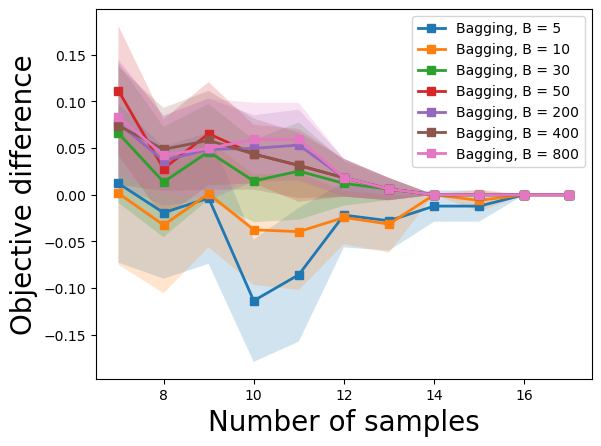

In [91]:
# B_list = [5, 10, 30, 50, 70, 100, 200, 400, 600, 800]
B_list = [5, 10, 30, 50, 'X', 'X', 200, 400, 'X', 800]
sample_number = np.array([2**i for i in range(7, 18)])
sample_number_log = np.log2(sample_number) 
figure_plot_B_CI(SAA_obj_lists, majority_obj_lists_B, sample_number_log, B_list)

In [30]:
parameters = {
    "seed": 2025,
    "m": 3,
    "a_ls": [2.0033248484659976, 1.9462659915572313, 2.0148555044660448],
    "r": [3.2701236422941093, 3.3207149493214994, 3.556858029428708],
    "c": 3.7856629820554946,
    "q": 1.7096129150007453,
    "ratio_list": [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8],
    # "ratio": 0.1,
    # "B_list": [5, 10, 30, 50, 70, 100, 200, 400, 600, 800],
    "B": 200,
    "number_of_iterations": 50,
    "sample_number": [2**i for i in range(7, 14)],
    "large_number_sample": 1000000
}

with open("parameters.json", "w") as f:
    json.dump(parameters, f, indent=2)

In [28]:
def figure_plot_R(SAA_obj_list, majority_obj_list_R, sample_number, ratio_list):
    _, ax = plt.subplots()
    ax.plot(sample_number, SAA_obj_list, marker = 'o', markeredgecolor = 'none', color = 'blue',linestyle = 'solid', linewidth = 2, label = 'SAA')
    for ind in range(len(majority_obj_list_R)):
        ax.plot(sample_number, majority_obj_list_R[ind], marker = 's', markeredgecolor = 'none', linestyle = 'solid', linewidth = 2, label = f'Bagging, Ratio = {ratio_list[ind]}')
    ax.set_xlabel('Number of samples', size = 20)
    ax.set_ylabel('Objective', size = 20)
    ax.legend(loc = 'lower right')
    plt.show()
    return

def figure_plot_R_CI(SAA_obj_lists, majority_obj_lists_R, sample_number, ratio_list):
    _, ax = plt.subplots()
    diff_obj_lists_R = []
    for ind1, R in enumerate(ratio_list):
        if R == 'X':
            diff_obj_lists_R.append([])
            continue
        diff_obj_lists = []
        for ind2, sample in enumerate(sample_number):
            diff_obj_list = [majority_obj_lists_R[ind1][ind2][i] - SAA_obj_lists[ind2][i] for i in range(50)]
            diff_obj_lists.append(diff_obj_list)
        diff_obj_lists_R.append(diff_obj_lists)
    
    for ind, R in enumerate(ratio_list):
        if R == 'X':
            continue
        diff_mean = np.mean(diff_obj_lists_R[ind], axis = 1)
        diff_std_err = stats.sem(diff_obj_lists_R[ind], axis = 1)
        diff_conf_int = 1.96 * diff_std_err

        ax.plot(sample_number, diff_mean, marker = 's', linestyle = 'solid', linewidth = 2, label = f'Bagging, Ratio = {R}')
        ax.fill_between(sample_number, diff_mean - diff_conf_int, diff_mean + diff_conf_int, alpha = 0.2)

    ax.set_xlabel('Number of samples', size = 20)
    ax.set_ylabel('Objective difference', size = 20)
    ax.set_ylim(-0.1, 0.2)
    ax.legend(loc = 'upper right')
    plt.show()

In [26]:
import json
with open("obj_lists_R.json", "r") as f:
    results = json.load(f)

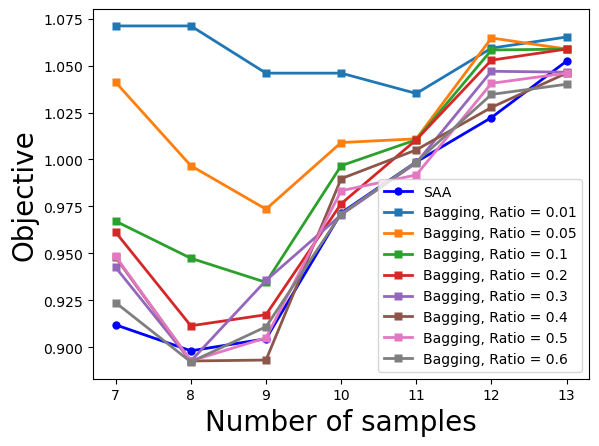

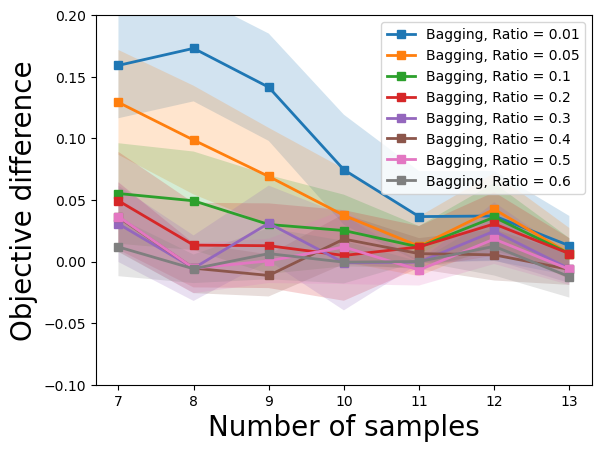

In [29]:
ratio_list = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
sample_number = np.array([2**i for i in range(7, 14)])
sample_number_log = np.log2(sample_number)
figure_plot_R(results["SAA_obj_list"], results["majority_obj_list_R"], sample_number_log, ratio_list)

# ratio_list=[0.01, 0.05, 'X', 'X', 'X', 'X']
figure_plot_R_CI(results["SAA_obj_lists"], results["majority_obj_lists_R"], sample_number_log, ratio_list)

In [1]:
import numpy as np
import json
from utils.plotting import plot_droComparison, plot_CI_droComparison

with open("obj_lists.json", "r") as f:
    results = json.load(f)


SAA_obj_avg = results["SAA_obj_avg"]
dro_wasserstein_obj_avg = results["dro_wasserstein_obj_avg"]
bagging_alg1_obj_avg = results["bagging_alg1_obj_avg"]
bagging_alg3_obj_avg = results["bagging_alg3_obj_avg"]
bagging_alg4_obj_avg = results["bagging_alg4_obj_avg"]

SAA_obj_list = results["SAA_obj_list"]
dro_wasserstein_obj_list = results["dro_wasserstein_obj_list"]
bagging_alg1_obj_list = results["bagging_alg1_obj_list"]
bagging_alg3_obj_list = results["bagging_alg3_obj_list"]
bagging_alg4_obj_list = results["bagging_alg4_obj_list"]


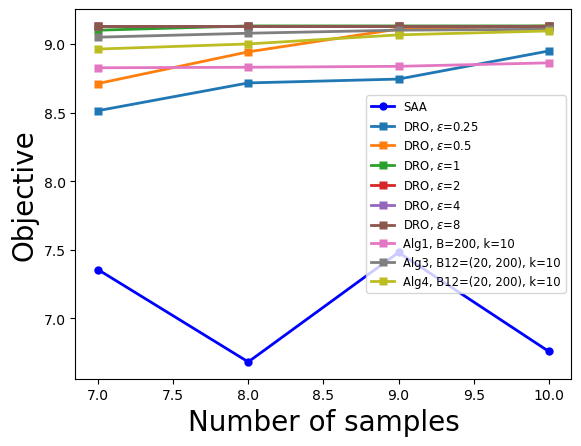

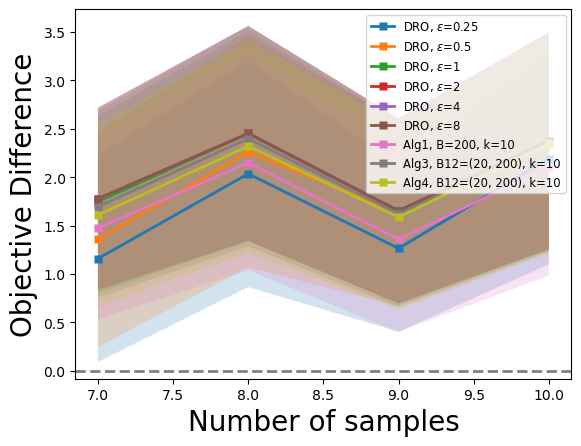

In [3]:
B_list = [200]
k_list = [10]
B12_list = [(20,200)]
sample_number = np.array([2**i for i in range(7, 11)])

# varepsilon_list = [0.015625,0.03125,0.0625,0.125,0.25,0.5,1,2, 4]
varepsilon_list = ['X', 'X', 'X', 'X', 0.25,0.5,1,2, 4, 8]

plot_droComparison(SAA_obj_avg, dro_wasserstein_obj_avg, bagging_alg1_obj_avg, bagging_alg3_obj_avg, bagging_alg4_obj_avg, np.log2(sample_number), B_list, k_list, B12_list, varepsilon_list)
plot_CI_droComparison(SAA_obj_list, dro_wasserstein_obj_list, bagging_alg1_obj_list, bagging_alg3_obj_list, bagging_alg4_obj_list, np.log2(sample_number), B_list, k_list, B12_list, varepsilon_list)